In [3]:
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from IPython import display
display.set_matplotlib_formats("svg")

C:\Users\Admin\AppData\Local\Temp\ipykernel_14144\906459842.py:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats("svg")


In [4]:
data = pd.read_csv("../FFN/mnist_train_small.csv", header=None)

# extract labels (number ID's) and remove from data
labels = data.values[:, 0]  # Convert DataFrame to NumPy before slicing
data = data.values[:, 1:]

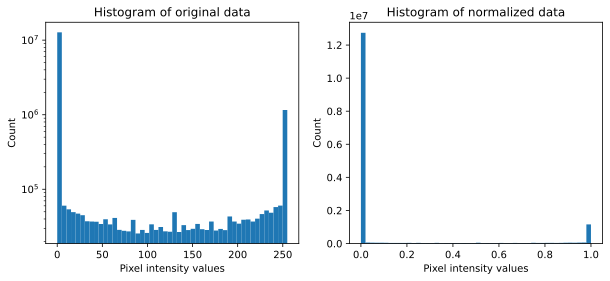

In [5]:
# normalize the data to a range of [0 1]
dataNorm = data/np.max(data)

fig, ax = plt.subplots(1, 2, figsize = (10, 4))
ax[0].hist(data.flatten(), 50)
ax[0].set_xlabel("Pixel intensity values")
ax[0].set_ylabel("Count")
ax[0].set_title("Histogram of original data")
ax[0].set_yscale("log")

ax[1].hist(dataNorm.flatten(), 50)
ax[1].set_xlabel("Pixel intensity values")
ax[1].set_ylabel("Count")
ax[1].set_title("Histogram of normalized data")

plt.show()

In [6]:
# Step 1: convert to tensor
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long()

# Step 2: use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, test_size = .1)

# Step 3: convert into Pytorch Datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Step 4: translate into dataloader objects
batchsize = 32
train_loader = DataLoader(train_data, batch_size = batchsize, shuffle = True, drop_last = True)
test_loader = DataLoader(test_data, batch_size = test_data.tensors[0].shape[0])

In [7]:
# check all variables in workspace
%whos

Variable           Type             Data/Info
---------------------------------------------
DataLoader         type             <class 'torch.utils.data.dataloader.DataLoader'>
F                  module           <module 'torch.nn.functio<...>orch\\nn\\functional.py'>
TensorDataset      type             <class 'torch.utils.data.dataset.TensorDataset'>
ax                 ndarray          2: 2 elems, type `object`, 16 bytes
batchsize          int              32
data               ndarray          20000x784: 15680000 elems, type `int64`, 125440000 bytes (119.62890625 Mb)
dataNorm           ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataT              Tensor           tensor([[0., 0., 0.,  ...<...>, 0.,  ..., 0., 0., 0.]])
display            module           <module 'IPython.display'<...>es\\IPython\\display.py'>
fig                Figure           Figure(1000x400)
labels             ndarray          20000: 20000 elems, type `int64`, 1600

In [8]:
# creating a class for the model
def createTheMNISTNet():
    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            # input layer
            self.input = nn.Linear(784, 64)

            # hidden layer
            self.fc1 = nn.Linear(64, 32)
            self.fc2 = nn.Linear(32, 32)

            # output layer
            self.output = nn.Linear(32, 10)

        # forward pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            return torch.log_softmax(self.output(x), axis = 1)

    # create the model instance
    net = mnistNet()

    # loss function
    lossfun = nn.NLLLoss()

    # optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr = .01) # Adam performs way too good for this model therefore we used SGD

    return net, lossfun, optimizer

In [9]:
# test the model with one batch
net, lossfun, optimizer = createTheMNISTNet()

X, y = next(iter(train_loader))
yHat = net(X)

# values are log-probability of each number (0-9)
print(yHat)

# now let's compute the loss
loss = lossfun(yHat, y)
print(" ")
print("Loss:")
print(loss)

tensor([[-2.1667, -2.3237, -2.4330, -2.2298, -2.2197, -2.2787, -2.4424, -2.2256,
         -2.3206, -2.4306],
        [-2.1759, -2.3429, -2.4298, -2.2406, -2.2209, -2.2755, -2.4378, -2.2025,
         -2.3163, -2.4278],
        [-2.1816, -2.3309, -2.4428, -2.2255, -2.2158, -2.2608, -2.4401, -2.2271,
         -2.3224, -2.4234],
        [-2.1719, -2.3594, -2.4357, -2.2334, -2.2145, -2.2608, -2.4373, -2.2134,
         -2.3195, -2.4265],
        [-2.1826, -2.3585, -2.4261, -2.2392, -2.2055, -2.2772, -2.4278, -2.2175,
         -2.3051, -2.4289],
        [-2.1842, -2.3571, -2.4333, -2.2308, -2.2163, -2.2596, -2.4351, -2.2073,
         -2.3134, -2.4346],
        [-2.1671, -2.3387, -2.4310, -2.2542, -2.2086, -2.2891, -2.4425, -2.2046,
         -2.3192, -2.4154],
        [-2.1622, -2.3422, -2.4301, -2.2331, -2.2154, -2.2788, -2.4375, -2.2255,
         -2.3256, -2.4196],
        [-2.1583, -2.3406, -2.4254, -2.2450, -2.2041, -2.2999, -2.4380, -2.2216,
         -2.3132, -2.4248],
        [-2.1790, -

In [10]:
 # train the model

def trainTheModel():

    # training parameter
    numepochs = 10
    
    # create a new model
    net, lossfun, optimizer = createTheMNISTNet()
    
    trainAcc = []
    testAcc = []
    losses = torch.zeros(numepochs)
    
    # train the model
    for epochi in range(numepochs):
        
        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, y)
            
            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute training accuracy for this batch
            matches = torch.argmax(yHat, axis = 1) == y # booleans (false/true); selects the class with the highest predicted probability for each input.
            # The == operator compares the predicted class to the actual class, returning a Boolean tensor (True for correct predictions, False for incorrect).
            matchesNumeric = matches.float() # convert to numbers (0/1)
            accuracyPct = 100*torch.mean(matchesNumeric) # avg and * by 100
            batchAcc.append(accuracyPct)
            
        # now that we've trained through the batches, get avg training accuracy
        trainAcc.append(np.mean(batchAcc))

        # get avg losses over the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        X, y = next(iter(test_loader))  # extract X, y from test dataloader
        yHat = net(X)

        # compute test accuracy
        testAcc.append(100 * torch.mean((torch.argmax(yHat, axis = 1) == y).float()))
        
    # function output
    return trainAcc, testAcc, losses, net

In [11]:
trainAcc, testAcc, losses, net = trainTheModel()

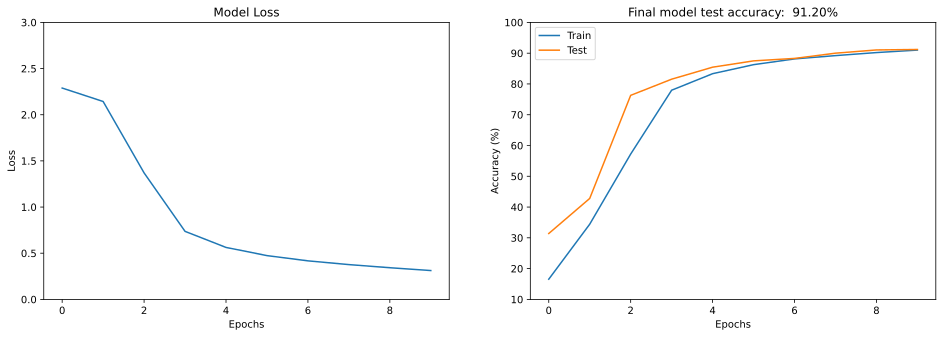

In [12]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))

ax[0].plot(losses)
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_ylim([0, 3])
ax[0].set_title("Model Loss")

ax[1].plot(trainAcc, label = "Train")
ax[1].plot(testAcc, label = "Test")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_ylim([10, 100])
ax[1].set_title(f"Final model test accuracy: {testAcc[-1]: .2f}%")
ax[1].legend()

plt.show()

In [13]:
# run the model thru for the test data
X, y = next(iter(test_loader))
predictions = net(X).detach()

torch.exp(predictions)

tensor([[6.4297e-06, 1.1088e-07, 1.2390e-07,  ..., 2.5637e-07, 6.4940e-05,
         1.4400e-05],
        [9.3867e-04, 2.5188e-03, 9.7649e-01,  ..., 5.9247e-05, 8.8787e-03,
         5.7200e-06],
        [5.5912e-03, 2.5989e-05, 9.9163e-01,  ..., 7.6999e-05, 9.1728e-04,
         3.5499e-06],
        ...,
        [1.4484e-05, 4.7635e-06, 5.8186e-04,  ..., 2.7711e-06, 9.8466e-01,
         1.2937e-03],
        [1.2009e-05, 8.3229e-08, 1.5821e-03,  ..., 9.3242e-11, 6.9066e-05,
         2.9355e-08],
        [8.5534e-05, 4.7746e-06, 3.0092e-04,  ..., 6.9140e-10, 7.4682e-04,
         1.5856e-06]])

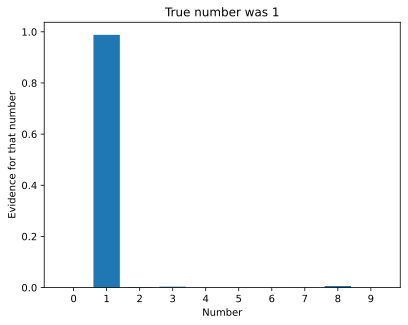

In [14]:
# Evidence for all numbers from one sample
sample2show = 120

plt.bar(range(10), torch.exp(predictions[sample2show]))
plt.xticks(range(10))
plt.xlabel("Number")
plt.ylabel("Evidence for that number")
plt.title("True number was %s" %y[sample2show].item())
plt.show()

[   3    5    6   28   42   55  141  162  169  172  174  180  223  227
  228  230  232  243  246  252  257  268  284  309  311  313  348  350
  352  358  363  383  394  404  406  414  415  449  451  476  486  497
  501  516  530  547  548  564  576  577  583  584  596  618  622  628
  646  647  654  657  677  678  690  716  718  734  737  741  805  815
  833  840  841  842  843  844  846  852  854  866  906  921  945  951
  970  973  974  996  997 1002 1007 1042 1097 1100 1113 1117 1130 1131
 1136 1149 1150 1151 1182 1186 1192 1202 1229 1241 1248 1250 1257 1272
 1291 1301 1313 1321 1323 1326 1328 1345 1353 1355 1364 1378 1379 1387
 1420 1423 1477 1491 1504 1513 1524 1555 1563 1566 1597 1631 1634 1665
 1676 1693 1719 1724 1728 1739 1741 1753 1770 1780 1781 1795 1798 1801
 1802 1806 1828 1846 1849 1872 1882 1903 1912 1922 1924 1925 1926 1933
 1947 1950 1952 1956 1966 1972 1983 1984]


C:\Users\Admin\AppData\Local\Temp\ipykernel_14144\703362624.py:10: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax[0].bar(range(10), np.exp(predictions[errors[sample2show]]))


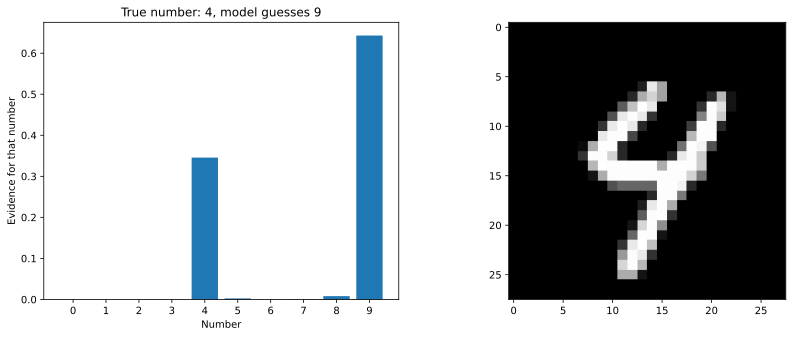

In [15]:
# find the errors
errors = np.where(torch.max(predictions, axis = 1)[1] != y)[0]
print(errors)

# Evidence for all numbers from one sample
sample2show = 4

fig, ax = plt.subplots(1, 2, figsize = (14, 5))

ax[0].bar(range(10), np.exp(predictions[errors[sample2show]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel("Number")
ax[0].set_ylabel("Evidence for that number")
ax[0].set_title("True number: %s, model guesses %s" 
               %(y[errors[sample2show]].item(), torch.argmax(predictions[errors[sample2show]]).item()))
ax[1].imshow(np.reshape(X[errors[sample2show], :], (28, 28)), cmap = "gray")
plt.show()

In [16]:
# save the model
torch.save(net.state_dict(), "trainedModel.pt")

In [17]:
# create two new models of the same class
model1 = createTheMNISTNet()[0]
model2 = createTheMNISTNet()[0]

# replace one model's parameters with those of the trained net
model1.load_state_dict(torch.load("trainedModel.pt"))

<All keys matched successfully>

In [18]:
# get some data from the test loader
X, y = next(iter(test_loader))

# run the data thru both models
yHatNet = net(X)
yHatModel1 = model1(X)
yHatModel2 = model2(X)

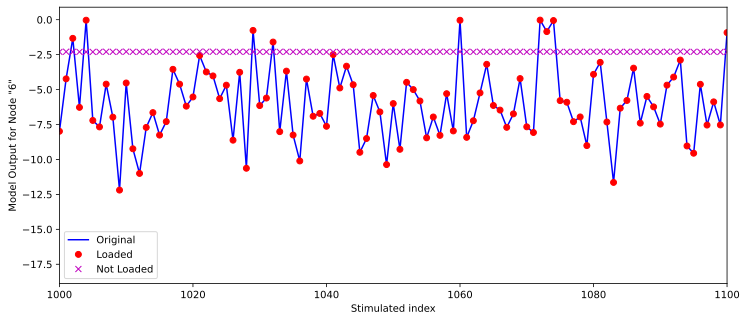

In [19]:
# show that the results overlap
fig = plt.figure(figsize = (12, 5))
plt.plot(yHatNet[:, 5].detach(), "b", label = "Original")
plt.plot(yHatModel1[:, 5].detach(), "ro", label = "Loaded")
plt.plot(yHatModel2[:, 5].detach(), "mx", label = "Not Loaded")
plt.legend()
plt.xlabel("Stimulated index")
plt.ylabel('Model Output for Node "6"')
plt.xlim([1000, 1100])

plt.show()